In [1]:
%load_ext autoreload
%autoreload 2
from ne_spectrum import _plot_embedding, TSNESpectrum, CNESpectrum
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, ConnectionPatch
from utils.plot_utils import  set_bounds, get_time_trajectory, get_time_midpoints, draw_time_trajectory, turn_label_to_days
from utils.utils import get_path, get_close_spec_params, load_human

/.pyenv/versions/miniconda3-latest/envs/miniumap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_path = get_path("data")
style_path = get_path("style")
fig_path = root_path + "/figures"
dataset = "human-409b2"

In [3]:
plt.style.use(style_path)   

In [4]:
# load metadata
_, y, d = load_human(root_path=root_path)

In [39]:
def plot_main_figure(embeddings, idx, y, d, fig_path, selected_params, spectrum_via):
    
    letters = "abcdefghi"
    
    np.random.seed(0)
    plot_order = np.random.permutation(np.arange(len(y)))
    
    
    mosaic = f"""{letters[:len(selected_params)]}\n{letters[len(selected_params)]*len(selected_params)}"""
    fig, ax_dict = plt.subplot_mosaic(mosaic,
                                      figsize=(7.2,2),
                                      height_ratios=[1, 0.2],
                                      )
    
    ax = [ax_dict[letter] for letter in mosaic.split("\n")[0]]
        
    for i, cax in enumerate(ax):
        embd = embeddings[idx[i]][plot_order]
        cax = _plot_embedding(ax=cax, embedding=embd, color=[d["label_colors"][label] for label in y[plot_order]], size=0.5, scalebar=False)
          
        cax = set_bounds(cax, embd, 0.01)
        cax.title.set_size(7)
        cax.collections[0].set_rasterized(True)
    
    # add spectrum

    text_y_pos = 0.9
    arrow_shift = 0.1
    
    rel_width = 0.85
    arrow_start = (1-rel_width)/2
    arrow_end = 1.0-(1-rel_width)/2
    
    cax = ax_dict[letters[len(selected_params)]]
    
    annot = plt.Annotation(
        "",
        xy=(arrow_start, text_y_pos+arrow_shift), 
        xycoords=cax.transAxes,
        xytext=(arrow_end, text_y_pos+arrow_shift), 
        textcoords=cax.transAxes,
        arrowprops=dict(arrowstyle="<->", linewidth=1.),
        zorder=10
    )
    cax.add_artist(annot)
    
    text_shift = 0.025
    cax.text(arrow_start+text_shift, text_y_pos-0.5,  "More repulsion\n"+r"emphasizes local structure", transform=cax.transAxes, ha="left", va="center", fontsize=9)
    cax.text(arrow_end-text_shift, text_y_pos-0.5,  "More attraction\n"+r"emphasizes global structure", transform=cax.transAxes, ha="right", va="center", fontsize=9)
    
    cax.axis("off")
    
    # UMAP / t-SNE positions
    if spectrum_via == "tsne":
        method_names = ["t-SNE",  r"$\approx$ UMAP",  r"$\approx$ ForceAtlas"]
    elif spectrum_via == "cne":
        method_names = [r"$\approx t$-SNE",  r"$\approx$ UMAP",  r"$\approx$ ForceAtlas"]
    else:
        raise ValueError("spectrum_via must be either 'tsne' or 'cne'")
    
    
    for i in range(3):
        ax[2*i].text(0.5, 1.0, method_names[i], transform=ax[2*i].transAxes, ha="center", va="center", fontsize=7)       
    
    # get time trajectories
    panel_nb = -1 
    embd = embeddings[idx[panel_nb]]
    ax[panel_nb] = draw_time_trajectory(ax=ax[panel_nb], embd=embd, y=y, d=d, s=0, alpha=0.75)
    
    # add time labels 
    panel_nb = -1
    embd = embeddings[idx[panel_nb]]
    time_midpoints, labels = get_time_midpoints(embd, y, d)
    
    if spectrum_via == "tsne":
        shifts = [(0.75, 0),
              (0, -0.7),
              (0.5, -0.6),        
              (0.7, -0.2),
              (0, -0.7),        
              (-0.25, 0.4),
              (0.7, 0.5),        
              ]   
    elif spectrum_via == "cne":
        shifts = [(-0.5, 0),
              (0, -0.7),
              (0.5, -0.6),        
              (0.7, -0.2),
              (0, -0.7),        
              (-0.25, 0.4),
              (0.7, 0.5),        
              ]   
    else:
        raise ValueError("spectrum_via must be either 'tsne' or 'cne'")
        
    label_to_days = {label: turn_label_to_days(label, d)  for label in labels}
    
    # add text
    for i, label in enumerate(labels):
        #time = d["color_to_time"][d["label_colors"][label]]
        time = label_to_days[label]
        color = d["label_colors"][label]
        ax[panel_nb].text(time_midpoints[i, 0]+shifts[i][0], 
                          time_midpoints[i, 1]+shifts[i][1],
                          s = time, 
                          fontdict={"color":color},
                          fontsize=7, ha="center", va="center")
        
        # add point to trajectory
        ax[panel_nb].scatter(time_midpoints[i, 0], time_midpoints[i, 1], color=color, s=20, zorder=10, edgecolor="black", linewidth=0.5)
    
    
    # add word "Development"
    ax[-1].text(0.2, 0.7, "Development", transform=ax[-1].transAxes, ha="center", va="center", fontsize=7, rotation=30)

    
    extra_colors = np.array(["gray", "magenta", "k"])
    
    clusters = np.unique(d["clusters"])
    y_cluster = np.zeros_like(y, dtype=int)
    for i, c in enumerate(clusters):
        y_cluster[d["clusters"] == c] = i
    tsne_embd = embeddings[idx[0]]
    
    if spectrum_via == "tsne":
        cluster_mask =  (y == "Organoid-1M") * (tsne_embd[:, 0] > -20) * (tsne_embd[:, 0] < 0) * (tsne_embd[:, 1] < -10)
    else:
        cluster_mask =  (y == "Organoid-1M") * (tsne_embd[:, 0] > -10) * (tsne_embd[:, 0] < 0) * (tsne_embd[:, 1] < -3)
    
    
    if spectrum_via == "tsne":
        bounds = (0.75,0.7, 0.3, 0.3)

    else:
        bounds = (0.7,0.725, 0.3, 0.3)

    inset_ax = ax[0].inset_axes(bounds=bounds)

    # cluster 18 is ventral progenitors and neurons 2, cluster 11 is midbrain/hindbrain cells, rest is background and plotted gray
    sub_cluster_values = ((y_cluster[cluster_mask] == 18) + 2*(y_cluster[cluster_mask] == 11)).astype(int)
    
    # Plotting on the inset axes, zooming in on a particular part of the main plot
    _plot_embedding(ax=inset_ax, embedding=tsne_embd[cluster_mask], color=extra_colors[sub_cluster_values], scalebar=False)
    inset_ax.collections[0].set_rasterized(True)
    
    # add rectangles and connection lines
    if spectrum_via == "tsne":
        rect_area = [-18, -28, 20, 20]  # x, y, width, height
    else:
        rect_area = [-9, -14, 10, 10]

    rect = Rectangle((rect_area[0], rect_area[1]), rect_area[2], rect_area[3], 
                     edgecolor='black', facecolor='none', lw=0.5)
    ax[0].add_patch(rect)
    
    
    inset_rect = Rectangle((0.0, 0.0), 1, 1, transform=inset_ax.transAxes, 
                           edgecolor='black', facecolor='none', lw=0.5, zorder=10, clip_on=False)
    inset_ax.add_patch(inset_rect)
    
    # connecting lines
    
    xy = (rect_area[0] + rect_area[3], rect_area[1])
    xy2 = (1, 0)
    con = ConnectionPatch(xyA=xy2, xyB=xy, coordsA="axes fraction", coordsB="data",
                          axesA=inset_ax, axesB=ax[0], color="black", linestyle="--", linewidth=0.5)
    fig.add_artist(con)
    
    xy = (rect_area[0], rect_area[1]+rect_area[3])
    xy2 = (0, 1)
    con = ConnectionPatch(xyA=xy2, xyB=xy, coordsA="axes fraction", coordsB="data",
                          axesA=inset_ax, axesB=ax[0], color="black", linestyle="--", linewidth=0.5)
    fig.add_artist(con)    
    fig.savefig(os.path.join(fig_path, f"main_fig_{spectrum_via}.pdf"), dpi=900)

# t-SNE spectrum

In [40]:
spectrum_via = "tsne"
seed = 2
n_slides = 60
min_spec_param = 0.85
max_spec_param = 30.0

In [41]:
# load embeddings
file_name =(f"{dataset}_{spectrum_via}_seed_{seed}_n_slides_{n_slides}"
            f"_min_spec_{min_spec_param}_max_spec_{max_spec_param}") # f"{dataset}_slider_defaults.npy"

embeddings = np.load(os.path.join(root_path, dataset, file_name+".npy")) @ np.array([[-1, 0], [0, 1]])

In [42]:
selected_exagg = np.array([30, 15, 5, 2.5, 1])[::-1]

_, idx, _ = get_close_spec_params(selected_exagg, spectrum_via=spectrum_via)

In [43]:
print(selected_exagg)

[ 1.   2.5  5.  15.  30. ]


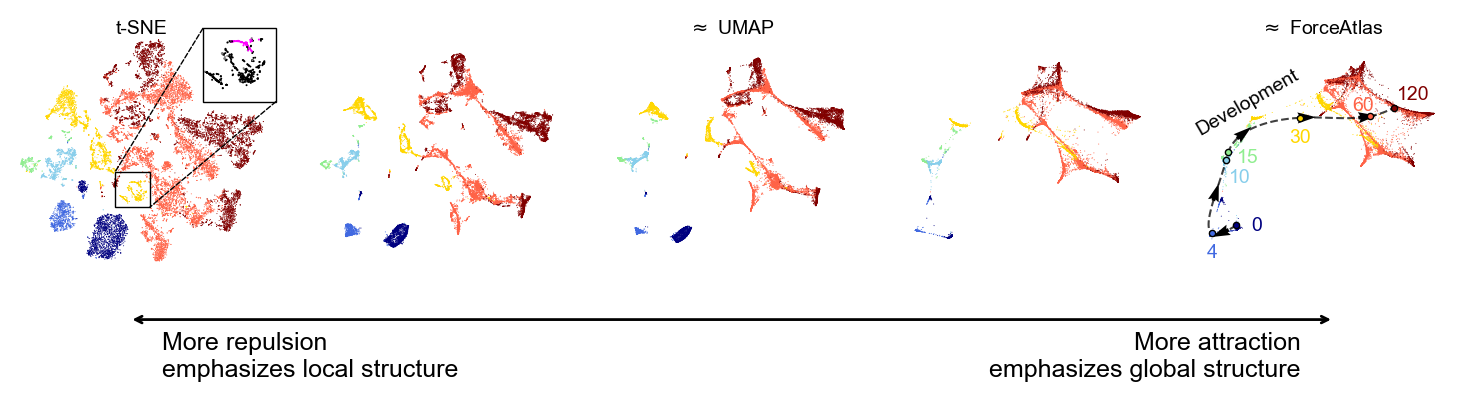

In [44]:
plot_main_figure(embeddings=embeddings, idx=idx, y=y, d=d, fig_path=fig_path, selected_params=selected_exagg, spectrum_via=spectrum_via)

In [111]:
spectrum = TSNESpectrum(num_slides=n_slides,
                        min_exaggeration=min_spec_param,
                        max_exaggeration=max_spec_param)

spectrum.load_embeddings(os.path.join(root_path, dataset, file_name+".npy"))


# rotate embeddings to align with the main figure
spectrum.embeddings = spectrum.embeddings @ np.array([[-1, 0], [0, 1]])

spectrum.save_video(save_path=fig_path, file_name=file_name+".gif", color=[d["label_colors"][label] for label in y], size=5.0, scalebar=False, title="")

# CNE spectrum

In [45]:
spectrum_via = "cne"
seed = 0
n_slides = 60
min_spec_param = -0.1
max_spec_param = 2.0

In [46]:
# load embeddings
file_name =(f"{dataset}_{spectrum_via}_seed_{seed}_m_50_epochs_50_n_slides_{n_slides}"
            f"_min_spec_{min_spec_param}_max_spec_{max_spec_param}") # f"{dataset}_slider_defaults.npy"

embeddings = np.load(os.path.join(root_path, dataset, file_name + ".npy")) @ np.array([[-1, 0], [0, 1]])

In [47]:
selected_spec_params = np.array([2.0, 1.5, 1.0, 0.5, 0.0])[::-1]

_, idx, computed_spec_params = get_close_spec_params(selected_spec_params, spectrum_via=spectrum_via)

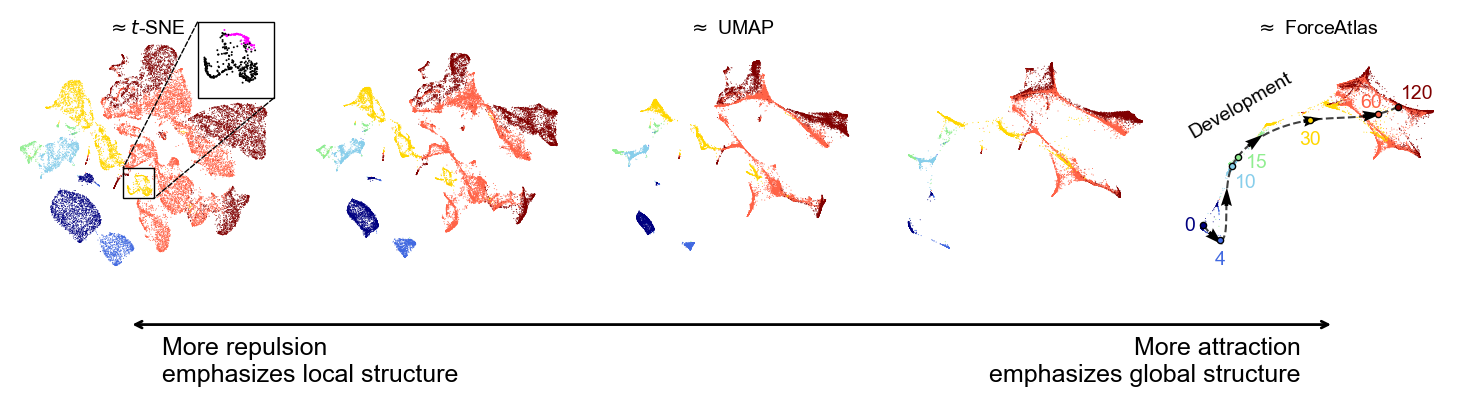

In [48]:
plot_main_figure(embeddings=embeddings, idx=idx, y=y, d=d, fig_path=fig_path, selected_params=selected_spec_params, spectrum_via=spectrum_via)

In [107]:
spectrum = CNESpectrum(num_slides=n_slides,
                       min_exaggeration=min_spec_param,
                       max_exaggeration=max_spec_param)

spectrum.load_embeddings(os.path.join(root_path, dataset, file_name + ".npy"))

# rotate embeddings to align with the main figure
spectrum.embeddings = spectrum.embeddings @ np.array([[-1, 0], [0, 1]])

spectrum.save_video(save_path=fig_path, file_name=file_name+".gif", color=[d["label_colors"][label] for label in y], size=5.0, scalebar=False, title="")